In [1]:
import numpy as np
import sklearn as sk
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.patches as patches

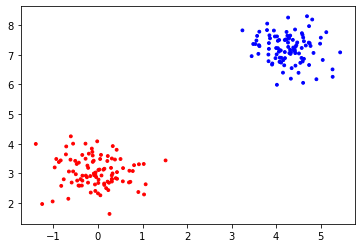

In [2]:
blobs, blob_labels = sk.datasets.make_blobs(n_samples=200, n_features=2, center_box=(0, 10.0), centers=2, cluster_std=0.5, random_state=1)
blobs = blobs.round(3)
plt.scatter(blobs[:, 0], blobs[:, 1], c=blob_labels, cmap="bwr", s=8);

In [18]:
k = 2
D = 0.000005 #0.0000005
eps = 0.1
X = blobs
n_initial = len(X) # the size of the current point set, a.k.a. n is all of the initial points

In [19]:
def visualize_splitting(Z, c_centers, lines, X, initial_bbox, title="Sub-Cell Construction"):
    plt.figure(figsize=(8, 6))

    # Plot the initial bounding box
    bbox = np.array(initial_bbox)
    plt.plot(bbox[:, 0], bbox[:, 1], color='green', linestyle='-', linewidth=1) #label='Initial Bounding Box'

    # Plot the original points
    plt.scatter(X[:, 0], X[:, 1], color='blue', marker='.', label='Original Points')

    # Plot points in light cells
    #for points_in_cell in Z:
    #    cell_points = np.array(points_in_cell)
    #    plt.scatter(cell_points[:, 0], cell_points[:, 1], color='orange', label='Light Cell')

    # Plot cell centers
    centers = np.array(c_centers)
    plt.scatter(centers[:, 0], centers[:, 1], color='red', marker='x', label='Cell Centers', s=45)

    # Plot the splitting lines
    for line in lines:
        for rect_coords in line:
            rect = patches.Rectangle(
                (rect_coords[0][0], rect_coords[1][0]),  # Bottom-left and top-right corner
                rect_coords[0][1] - rect_coords[0][0],   # Width
                rect_coords[1][1] - rect_coords[1][0],   # Height
                edgecolor='green', facecolor='none')
            plt.gca().add_patch(rect)

    plt.title(title)
    plt.axis("off")
    #plt.xlabel('X-axis')
    #plt.ylabel('Y-axis')
    plt.legend()
    plt.grid(False)
    plt.show()

In [20]:
def recursive_split(X, cell, k, D, eps, opt, n_initial, delta, nr_of_cells, cs, i, lines, Z, c_centers):
    x1, x2, y1, y2 = cell
    points_in_cell = X[(X[:, 0] >= x1) & (X[:, 0] < x2) & (X[:, 1] >= y1) & (X[:, 1] < y2)]
    
    threshold = delta*opt / pow(2, i)
    print("Threshold value:", round(threshold, 5), "Points in cell:", len(points_in_cell))
    if len(points_in_cell) < threshold:
        # If there are less than the threshold number of points, it's a light cell
        # First time this is checked, it checks the grid g**i if it is light (step #3)
        # Afterwards when it recurs it does step #3.4, marks c as a light cell and adds it to Z
        # Also when it recurs it does step #3.5 here (delete c from Y) as the light cell c will no longer be recured
        
        if len(points_in_cell) >= 1: 
            print("\033[1m Points in light cell:\n", points_in_cell, "\033[0;0m")
            # If c is not empty (this already checks step #4)
            Z.append(points_in_cell)
            # Save the center coordinates for step #4.1
            c_centers.append(((x1 + x2) / 2, (y1 + y2) / 2))
    else: 
        print("Current number of cells: " + str(nr_of_cells))
        # Cell counter, each time a cell gets split into 4 subcells the total increases by 3
        nr_of_cells = nr_of_cells + 3

        # The would-be number of cells if the below code executes
        # Does not allow to create more subcells than cs
        if i>=0:  #i-1 >= np.log(delta * opt) + 1 and nr_of_cells <= cs
        
            # Step #3.1 if c is heavy then
            # Split the cell
            # First time this executes - only if g**i is heavy and splits it into 4 sub-cells c1, c2, c3, c4 (step #3)
            # Afterwards the level of each cell goes to g**i-1, with side length 2**i-1 with each recursion
            i = i - 1
            mid_x = (x1 + x2) / 2
            mid_y = (y1 + y2) / 2
            
            lines.append([
                ((x1, mid_x), (y1, mid_y)),  # Top-left
                ((mid_x, x2), (y1, mid_y)),  # Top-right
                ((x1, mid_x), (mid_y, y2)),  # Bottom-left
                ((mid_x, x2), (mid_y, y2))])  # Bottom-right
            
            cells = [
                (x1, mid_x, y1, mid_y),  # Top-left
                (mid_x, x2, y1, mid_y),  # Top-right
                (x1, mid_x, mid_y, y2),  # Bottom-left
                (mid_x, x2, mid_y, y2)   # Bottom-right
            ]
            # Step #3.2 and #3.3 as it implicitly adds c1, c2, c3, c4 to Y with each recursion below
            for sub_cell in cells:
                recursive_split(points_in_cell, sub_cell, k, D, eps, opt, n_initial, delta, nr_of_cells, cs, i, lines,
                                Z, c_centers)
    return Z, c_centers, lines

In [21]:
def coreset(Z, rep_c, delta, cs, eps):
    
    # rep_c = c_centers = representative center point of a cell
    # n_c = number of  points in each cell
    n_c = [len(c) for c in Z]
    
    # S = pairs respective center coordinates with number of points in each cell
    S = []
    for index in range(0, len(rep_c)):
        S.append([rep_c[index], n_c[index]])
    #print(rep_c, n_c)
    if len(S) > cs*(1+eps) or len(S) == 0:
        return None # failure indication
    else:
        return S

In [22]:
def coreset_construction(X, k, D, eps, n_initial):
    
    if X.size > 0: 
        print("The array is non-empty, proceeding with coreset construction algorithm")
        
        # Step #1: Define the boundaries of the coordinate plane, at the start let Y be the only cell in grid g^(log(D))
        x_min, x_max, y_min, y_max = min(X[:, 0]), max(X[:, 0]), min(X[:, 1]), max(X[:, 1])
        Y = x_min, x_max, y_min, y_max
        
        # Calculate delta
        delta = ( 1 / ( (4*k*np.sqrt(D)) * (np.log(n_initial)+1) ) ) * pow( ( eps / (14*np.sqrt(D)) ), D)
        print("delta =", round(delta, 5))
        # Calculate coreset size
        cs = 2/delta + (np.log(n_initial) + 2) * k * pow(2, D)
        print("cs =", round(cs, 5))
        DELTA = 5 # take DELTA as an arbitrary constant, lets say 5
        # Opt = number of guesses for opt approx., round up: (delta+1) * log_base(1 + eps)(DELTA) * (sqrt(2))
        Opt = -int(- ((delta+1) * (np.log(np.sqrt(DELTA))/np.log(1 + eps)) * np.sqrt(2)) // 1)
        print("Number of guesses for opt approximation =", Opt)

        for j in range(0, Opt):
            print("\nIteration j = " + str(j) + ", with approximation Opt = (1+eps)^j = " + str(pow((1+eps), j)) + "\n")
            
            # Cell counter
            nr_of_cells = 1
            # i-th iteration tracking for recursive alg
            i = DELTA
            # Lines defining sub-cell boundries
            lines = []
            # Step #0: arr to store light cells c
            Z = []
            # Cell centers
            c_centers = []

            # Start the recursive splitting, here Opt = (1+eps)^j
            Z, c_centers, lines = recursive_split(X, Y, k, D, eps, pow((1+eps), j), n_initial,
                                                  delta, nr_of_cells, cs, i, lines, Z, c_centers)
            # Start the coreset calculation
            S = coreset(Z, c_centers, delta, cs, eps)
                        
            if S is not None:
                print("\n Coreset constructed: \n", S)
                
                initial_bbox = [[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max], [x_min, y_min]]
                visualize_splitting(Z, c_centers, lines, X, initial_bbox)
                
                return S
        return "Coreset could not be constructed"
    else:
        return "The array is empty."

The array is non-empty, proceeding with coreset construction algorithm
delta = 8.87571
cs = 14.82202
Number of guesses for opt approximation = 118

Iteration j = 0, with approximation Opt = (1+eps)^j = 1.0

Threshold value: 0.27737 Points in cell: 198
Current number of cells: 1
Threshold value: 0.55473 Points in cell: 100
Current number of cells: 4
Threshold value: 1.10946 Points in cell: 51
Current number of cells: 7
Threshold value: 2.21893 Points in cell: 3
Current number of cells: 10
Threshold value: 4.43785 Points in cell: 1
 Points in light cell:
 [[-1.252  1.966]] 
Threshold value: 4.43785 Points in cell: 0
Threshold value: 4.43785 Points in cell: 1
 Points in light cell:
 [[-1.017  2.052]] 
Threshold value: 4.43785 Points in cell: 1
 Points in light cell:
 [[-0.665  2.143]] 
Threshold value: 2.21893 Points in cell: 6
Current number of cells: 10
Threshold value: 4.43785 Points in cell: 0
Threshold value: 4.43785 Points in cell: 1
 Points in light cell:
 [[0.259 1.632]] 
Threshol

Threshold value: 11.81357 Points in cell: 1
 Points in light cell:
 [[3.824 7.005]] 
Threshold value: 11.81357 Points in cell: 4
 Points in light cell:
 [[3.983 6.884]
 [4.009 7.011]
 [4.115 6.895]
 [4.08  6.901]] 
Threshold value: 5.90678 Points in cell: 8
Current number of cells: 13
Threshold value: 11.81357 Points in cell: 2
 Points in light cell:
 [[4.179 6.642]
 [4.158 6.816]] 
Threshold value: 11.81357 Points in cell: 2
 Points in light cell:
 [[4.431 6.631]
 [4.54  6.726]] 
Threshold value: 11.81357 Points in cell: 2
 Points in light cell:
 [[4.32  7.027]
 [4.196 6.885]] 
Threshold value: 11.81357 Points in cell: 2
 Points in light cell:
 [[4.567 6.891]
 [4.51  7.043]] 
Threshold value: 5.90678 Points in cell: 7
Current number of cells: 13
Threshold value: 11.81357 Points in cell: 1
 Points in light cell:
 [[3.835 7.197]] 
Threshold value: 11.81357 Points in cell: 5
 Points in light cell:
 [[4.077 7.152]
 [3.998 7.225]
 [4.102 7.144]
 [4.059 7.103]
 [4.037 7.22 ]] 
Threshold val

Threshold value: 9.51293 Points in cell: 4
 Points in light cell:
 [[ 0.232  2.435]
 [ 0.     2.325]
 [-0.059  2.407]
 [ 0.054  2.26 ]] 
Threshold value: 4.75647 Points in cell: 6
Current number of cells: 10
Threshold value: 9.51293 Points in cell: 0
Threshold value: 9.51293 Points in cell: 3
 Points in light cell:
 [[-0.59   2.69 ]
 [-0.824  2.578]
 [-0.768  2.799]] 
Threshold value: 9.51293 Points in cell: 1
 Points in light cell:
 [[-0.971  3.2  ]] 
Threshold value: 9.51293 Points in cell: 2
 Points in light cell:
 [[-0.652  3.062]
 [-0.557  3.064]] 
Threshold value: 4.75647 Points in cell: 36
Current number of cells: 10
Threshold value: 9.51293 Points in cell: 8
 Points in light cell:
 [[-0.414  2.583]
 [-0.437  2.589]
 [-0.39   2.805]
 [-0.362  2.589]
 [-0.223  2.687]
 [-0.248  2.868]
 [-0.466  2.757]
 [-0.35   2.755]] 
Threshold value: 9.51293 Points in cell: 11
Current number of cells: 13
Threshold value: 19.02587 Points in cell: 1
 Points in light cell:
 [[-0.067  2.625]] 
Thre

Current number of cells: 7
Threshold value: 9.26901 Points in cell: 3
 Points in light cell:
 [[-0.665  2.143]
 [-1.252  1.966]
 [-1.017  2.052]] 
Threshold value: 9.26901 Points in cell: 6
 Points in light cell:
 [[-0.162  2.352]
 [ 0.232  2.435]
 [ 0.     2.325]
 [-0.059  2.407]
 [ 0.259  1.632]
 [ 0.054  2.26 ]] 
Threshold value: 9.26901 Points in cell: 6
 Points in light cell:
 [[-0.59   2.69 ]
 [-0.824  2.578]
 [-0.652  3.062]
 [-0.971  3.2  ]
 [-0.557  3.064]
 [-0.768  2.799]] 
Threshold value: 9.26901 Points in cell: 36
Current number of cells: 10
Threshold value: 18.53802 Points in cell: 8
 Points in light cell:
 [[-0.414  2.583]
 [-0.437  2.589]
 [-0.39   2.805]
 [-0.362  2.589]
 [-0.223  2.687]
 [-0.248  2.868]
 [-0.466  2.757]
 [-0.35   2.755]] 
Threshold value: 18.53802 Points in cell: 11
 Points in light cell:
 [[ 0.184  2.501]
 [-0.067  2.625]
 [ 0.139  2.657]
 [ 0.012  2.789]
 [ 0.008  2.676]
 [-0.041  2.875]
 [ 0.31   2.802]
 [ 0.247  2.683]
 [ 0.312  2.723]
 [ 0.142  2

Threshold value: 21.85584 Points in cell: 0
Threshold value: 10.92792 Points in cell: 7
 Points in light cell:
 [[0.919 3.306]
 [0.419 3.795]
 [1.517 3.436]
 [0.332 3.919]
 [1.027 3.316]
 [0.381 3.466]
 [0.506 3.483]] 
Threshold value: 5.46396 Points in cell: 0
Threshold value: 5.46396 Points in cell: 0
Threshold value: 5.46396 Points in cell: 98
Current number of cells: 4
Threshold value: 10.92792 Points in cell: 0
Threshold value: 10.92792 Points in cell: 9
 Points in light cell:
 [[4.5   6.39 ]
 [4.151 6.395]
 [4.015 5.986]
 [4.345 6.547]
 [5.266 6.255]
 [4.901 6.173]
 [4.603 6.052]
 [4.328 6.192]
 [5.263 6.505]] 
Threshold value: 10.92792 Points in cell: 10
 Points in light cell:
 [[3.612 7.32 ]
 [3.555 7.479]
 [3.448 6.951]
 [3.484 7.361]
 [3.571 7.635]
 [3.62  7.776]
 [3.623 7.288]
 [3.534 7.36 ]
 [3.599 7.029]
 [3.241 7.821]] 
Threshold value: 10.92792 Points in cell: 79
Current number of cells: 7
Threshold value: 21.85584 Points in cell: 41
Current number of cells: 10
Threshold

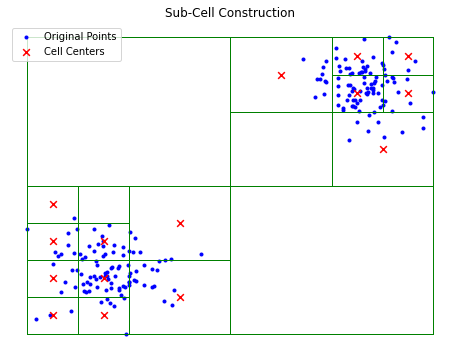

[[(-0.9681875, 2.0485625), 3],
 [(-0.11456250000000007, 2.0485625), 6],
 [(-0.9681875, 2.8816875), 6],
 [(-0.11456250000000007, 2.8816875), 36],
 [(1.1658749999999998, 2.465125), 15],
 [(-0.9681875, 3.7148125), 8],
 [(-0.11456250000000007, 3.7148125), 18],
 [(-0.9681875, 4.5479375), 1],
 [(1.1658749999999998, 4.131375), 7],
 [(4.580375, 5.797625), 9],
 [(2.873125, 7.463875000000001), 10],
 [(4.1535625, 7.0473125), 41],
 [(5.007187500000001, 7.0473125), 11],
 [(4.1535625, 7.880437500000001), 21],
 [(5.007187500000001, 7.880437500000001), 6]]

In [23]:
coreset_construction(X, k, D, eps, n_initial)

# Half circles (moons)

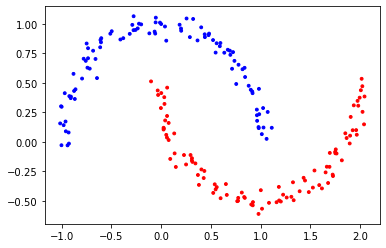

In [24]:
moons, moon_labels = sk.datasets.make_moons(n_samples=200, random_state=1, noise = 0.05)
moons = moons.round(3)
plt.scatter(moons[:, 0], moons[:, 1], c=moon_labels, cmap="bwr", s=8);

The array is non-empty, proceeding with coreset construction algorithm
delta = 8.87571
cs = 14.82202
Number of guesses for opt approximation = 118

Iteration j = 0, with approximation Opt = (1+eps)^j = 1.0

Threshold value: 0.27737 Points in cell: 198
Current number of cells: 1
Threshold value: 0.55473 Points in cell: 33
Current number of cells: 4
Threshold value: 1.10946 Points in cell: 0
Threshold value: 1.10946 Points in cell: 6
Current number of cells: 7
Threshold value: 2.21893 Points in cell: 0
Threshold value: 2.21893 Points in cell: 0
Threshold value: 2.21893 Points in cell: 0
Threshold value: 2.21893 Points in cell: 6
Current number of cells: 10
Threshold value: 4.43785 Points in cell: 0
Threshold value: 4.43785 Points in cell: 2
 Points in light cell:
 [[ 0.427 -0.306]
 [ 0.379 -0.364]] 
Threshold value: 4.43785 Points in cell: 1
 Points in light cell:
 [[ 0.147 -0.212]] 
Threshold value: 4.43785 Points in cell: 3
 Points in light cell:
 [[ 0.369 -0.28 ]
 [ 0.404 -0.233]
 [ 0

Threshold value: 11.81357 Points in cell: 0
Threshold value: 11.81357 Points in cell: 1
 Points in light cell:
 [[ 0.81  -0.429]] 
Threshold value: 2.95339 Points in cell: 12
Current number of cells: 10
Threshold value: 5.90678 Points in cell: 6
Current number of cells: 13
Threshold value: 11.81357 Points in cell: 1
 Points in light cell:
 [[ 0.978 -0.61 ]] 
Threshold value: 11.81357 Points in cell: 1
 Points in light cell:
 [[ 1.013 -0.566]] 
Threshold value: 11.81357 Points in cell: 3
 Points in light cell:
 [[ 0.92  -0.537]
 [ 0.922 -0.51 ]
 [ 0.905 -0.53 ]] 
Threshold value: 11.81357 Points in cell: 1
 Points in light cell:
 [[ 1.083 -0.516]] 
Threshold value: 5.90678 Points in cell: 1
 Points in light cell:
 [[ 1.159 -0.511]] 
Threshold value: 5.90678 Points in cell: 1
 Points in light cell:
 [[ 1.001 -0.409]] 
Threshold value: 5.90678 Points in cell: 4
 Points in light cell:
 [[ 1.261 -0.471]
 [ 1.225 -0.447]
 [ 1.202 -0.505]
 [ 1.185 -0.496]] 
Threshold value: 2.95339 Points in 

Threshold value: 1.96548 Points in cell: 14
Current number of cells: 7
Threshold value: 3.93096 Points in cell: 0
Threshold value: 3.93096 Points in cell: 6
Current number of cells: 10
Threshold value: 7.86193 Points in cell: 4
 Points in light cell:
 [[0.985 0.235]
 [0.961 0.274]
 [1.024 0.287]
 [1.07  0.254]] 
Threshold value: 7.86193 Points in cell: 0
Threshold value: 7.86193 Points in cell: 2
 Points in light cell:
 [[0.915 0.427]
 [0.918 0.413]] 
Threshold value: 7.86193 Points in cell: 0
Threshold value: 3.93096 Points in cell: 6
Current number of cells: 10
Threshold value: 7.86193 Points in cell: 0
Threshold value: 7.86193 Points in cell: 2
 Points in light cell:
 [[0.879 0.476]
 [0.754 0.491]] 
Threshold value: 7.86193 Points in cell: 0
Threshold value: 7.86193 Points in cell: 4
 Points in light cell:
 [[0.843 0.55 ]
 [0.838 0.628]
 [0.712 0.62 ]
 [0.817 0.616]] 
Threshold value: 3.93096 Points in cell: 2
 Points in light cell:
 [[0.9   0.442]
 [0.982 0.45 ]] 
Threshold value: 

 [[-0.201  0.996]
 [-0.223  1.002]
 [-0.236  0.962]] 
Threshold value: 11.51065 Points in cell: 5
 Points in light cell:
 [[-0.056  1.013]
 [ 0.038  0.978]
 [-0.012  1.011]
 [-0.     0.999]
 [-0.054  1.053]] 
Threshold value: 5.75532 Points in cell: 12
Current number of cells: 10
Threshold value: 11.51065 Points in cell: 2
 Points in light cell:
 [[0.288 0.888]
 [0.201 0.942]] 
Threshold value: 11.51065 Points in cell: 5
 Points in light cell:
 [[0.476 0.905]
 [0.439 0.888]
 [0.481 0.918]
 [0.437 0.912]
 [0.365 0.86 ]] 
Threshold value: 11.51065 Points in cell: 4
 Points in light cell:
 [[0.321 1.042]
 [0.185 0.993]
 [0.255 1.046]
 [0.199 0.961]] 
Threshold value: 11.51065 Points in cell: 1
 Points in light cell:
 [[0.402 0.971]] 
Threshold value: 1.43883 Points in cell: 34
Current number of cells: 4
Threshold value: 2.87766 Points in cell: 14
Current number of cells: 7
Threshold value: 5.75532 Points in cell: 0
Threshold value: 5.75532 Points in cell: 6
Current number of cells: 10
Thr

Threshold value: 9.26901 Points in cell: 11
Current number of cells: 10
Threshold value: 18.53802 Points in cell: 1
 Points in light cell:
 [[0.695 0.738]] 
Threshold value: 18.53802 Points in cell: 2
 Points in light cell:
 [[0.736 0.687]
 [0.777 0.654]] 
Threshold value: 18.53802 Points in cell: 7
 Points in light cell:
 [[0.589 0.811]
 [0.595 0.838]
 [0.669 0.781]
 [0.634 0.756]
 [0.557 0.836]
 [0.547 0.757]
 [0.69  0.773]] 
Threshold value: 18.53802 Points in cell: 1
 Points in light cell:
 [[0.722 0.761]] 
Threshold value: 9.26901 Points in cell: 0
Threshold value: 9.26901 Points in cell: 1
 Points in light cell:
 [[0.521 0.863]] 
Threshold value: 9.26901 Points in cell: 0
Threshold value: 4.6345 Points in cell: 0

Iteration j = 16, with approximation Opt = (1+eps)^j = 4.594972986357222

Threshold value: 1.27449 Points in cell: 198
Current number of cells: 1
Threshold value: 2.54898 Points in cell: 33
Current number of cells: 4
Threshold value: 5.09795 Points in cell: 0
Threshold 

 Points in light cell:
 [[-0.749  0.834]
 [-0.779  0.705]
 [-0.758  0.687]
 [-0.66   0.703]
 [-0.735  0.709]
 [-0.684  0.773]
 [-0.735  0.794]] 
Threshold value: 21.85584 Points in cell: 2
 Points in light cell:
 [[-0.605  0.844]
 [-0.613  0.802]] 
Threshold value: 21.85584 Points in cell: 0
Threshold value: 21.85584 Points in cell: 10
 Points in light cell:
 [[-0.278  0.947]
 [-0.61   0.864]
 [-0.511  0.917]
 [-0.602  0.879]
 [-0.41   0.868]
 [-0.316  0.916]
 [-0.381  0.879]
 [-0.258  0.949]
 [-0.29   0.992]
 [-0.497  0.938]] 
Threshold value: 10.92792 Points in cell: 24
Current number of cells: 7
Threshold value: 21.85584 Points in cell: 0
Threshold value: 21.85584 Points in cell: 0
Threshold value: 21.85584 Points in cell: 12
 Points in light cell:
 [[-0.056  1.013]
 [ 0.038  0.978]
 [-0.201  0.996]
 [-0.06   0.918]
 [-0.012  1.011]
 [-0.119  0.92 ]
 [-0.223  1.002]
 [ 0.051  0.858]
 [-0.066  0.935]
 [-0.     0.999]
 [-0.236  0.962]
 [-0.054  1.053]] 
Threshold value: 21.85584 Point

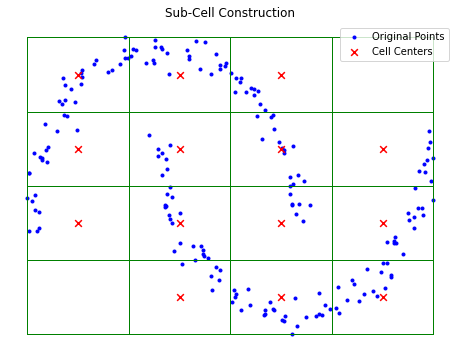

In [25]:
coreset_construction(moons, k, D, eps, len(moons)); 

The array is non-empty, proceeding with coreset construction algorithm
delta = 627.60367
cs = 14.59982
Number of guesses for opt approximation = 7506

Iteration j = 0, with approximation Opt = (1+eps)^j = 1.0

Threshold value: 19.61261 Points in cell: 198
Current number of cells: 1
Threshold value: 39.22523 Points in cell: 33
 Points in light cell:
 [[-1.015  0.157]
 [ 0.04   0.182]
 [ 0.229 -0.111]
 [-0.958  0.09 ]
 [-1.002 -0.028]
 [ 0.059  0.22 ]
 [ 0.026  0.113]
 [ 0.314 -0.169]
 [-0.941 -0.029]
 [ 0.147 -0.212]
 [ 0.091 -0.144]
 [ 0.131  0.072]
 [ 0.369 -0.28 ]
 [ 0.051  0.06 ]
 [ 0.075  0.016]
 [-0.98   0.142]
 [ 0.135 -0.097]
 [ 0.309 -0.138]
 [ 0.427 -0.306]
 [-0.927 -0.014]
 [ 0.024  0.12 ]
 [ 0.404 -0.233]
 [-0.961  0.173]
 [ 0.308 -0.157]
 [ 0.25  -0.191]
 [ 0.024  0.105]
 [ 0.075  0.161]
 [ 0.434 -0.246]
 [ 0.295 -0.111]
 [ 0.058  0.037]
 [ 0.344 -0.182]
 [-0.93   0.08 ]
 [ 0.379 -0.364]] 
Threshold value: 39.22523 Points in cell: 66
Current number of cells: 4
Threshold val

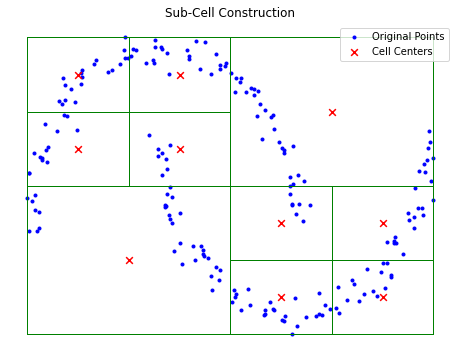

In [26]:
# Here can be demonstrated that different D value can lead to a different coreset
coreset_construction(moons, k, 0.000000001, eps, len(moons));

The array is non-empty, proceeding with coreset construction algorithm
delta = 5.91714
cs = 22.23303
Number of guesses for opt approximation = 83

Iteration j = 0, with approximation Opt = (1+eps)^j = 1.0

Threshold value: 0.18491 Points in cell: 198
Current number of cells: 1
Threshold value: 0.36982 Points in cell: 33
Current number of cells: 4
Threshold value: 0.73964 Points in cell: 0
Threshold value: 0.73964 Points in cell: 6
Current number of cells: 7
Threshold value: 1.47928 Points in cell: 0
Threshold value: 1.47928 Points in cell: 0
Threshold value: 1.47928 Points in cell: 0
Threshold value: 1.47928 Points in cell: 6
Current number of cells: 10
Threshold value: 2.95857 Points in cell: 0
Threshold value: 2.95857 Points in cell: 2
 Points in light cell:
 [[ 0.427 -0.306]
 [ 0.379 -0.364]] 
Threshold value: 2.95857 Points in cell: 1
 Points in light cell:
 [[ 0.147 -0.212]] 
Threshold value: 2.95857 Points in cell: 3
Current number of cells: 13
Threshold value: 5.91714 Points in 

Threshold value: 7.15974 Points in cell: 1
 Points in light cell:
 [[0.131 0.072]] 
Threshold value: 3.57987 Points in cell: 0
Threshold value: 3.57987 Points in cell: 3
 Points in light cell:
 [[0.04  0.182]
 [0.059 0.22 ]
 [0.075 0.161]] 
Threshold value: 1.78993 Points in cell: 0
Threshold value: 0.44748 Points in cell: 66
Current number of cells: 4
Threshold value: 0.89497 Points in cell: 26
Current number of cells: 7
Threshold value: 1.78993 Points in cell: 10
Current number of cells: 10
Threshold value: 3.57987 Points in cell: 0
Threshold value: 3.57987 Points in cell: 0
Threshold value: 3.57987 Points in cell: 4
Current number of cells: 13
Threshold value: 7.15974 Points in cell: 1
 Points in light cell:
 [[ 0.597 -0.477]] 
Threshold value: 7.15974 Points in cell: 0
Threshold value: 7.15974 Points in cell: 2
 Points in light cell:
 [[ 0.547 -0.402]
 [ 0.523 -0.432]] 
Threshold value: 7.15974 Points in cell: 1
 Points in light cell:
 [[ 0.659 -0.449]] 
Threshold value: 3.57987 Po

 [[-0.875  0.432]] 
Threshold value: 4.33164 Points in cell: 0
Threshold value: 2.16582 Points in cell: 0
Threshold value: 2.16582 Points in cell: 6
Current number of cells: 10
Threshold value: 4.33164 Points in cell: 1
 Points in light cell:
 [[-0.861  0.446]] 
Threshold value: 4.33164 Points in cell: 2
 Points in light cell:
 [[-0.795  0.537]
 [-0.645  0.541]] 
Threshold value: 4.33164 Points in cell: 1
 Points in light cell:
 [[-0.881  0.577]] 
Threshold value: 4.33164 Points in cell: 2
 Points in light cell:
 [[-0.718  0.621]
 [-0.741  0.629]] 
Threshold value: 2.16582 Points in cell: 0
Threshold value: 1.08291 Points in cell: 8
Current number of cells: 7
Threshold value: 2.16582 Points in cell: 6
Current number of cells: 10
Threshold value: 4.33164 Points in cell: 0
Threshold value: 4.33164 Points in cell: 2
 Points in light cell:
 [[-0.003  0.287]
 [ 0.033  0.322]] 
Threshold value: 4.33164 Points in cell: 0
Threshold value: 4.33164 Points in cell: 4
 Points in light cell:
 [[-0.


Threshold value: 0.39637 Points in cell: 198
Current number of cells: 1
Threshold value: 0.79274 Points in cell: 33
Current number of cells: 4
Threshold value: 1.58549 Points in cell: 0
Threshold value: 1.58549 Points in cell: 6
Current number of cells: 7
Threshold value: 3.17098 Points in cell: 0
Threshold value: 3.17098 Points in cell: 0
Threshold value: 3.17098 Points in cell: 0
Threshold value: 3.17098 Points in cell: 6
Current number of cells: 10
Threshold value: 6.34196 Points in cell: 0
Threshold value: 6.34196 Points in cell: 2
 Points in light cell:
 [[ 0.427 -0.306]
 [ 0.379 -0.364]] 
Threshold value: 6.34196 Points in cell: 1
 Points in light cell:
 [[ 0.147 -0.212]] 
Threshold value: 6.34196 Points in cell: 3
 Points in light cell:
 [[ 0.369 -0.28 ]
 [ 0.404 -0.233]
 [ 0.434 -0.246]] 
Threshold value: 1.58549 Points in cell: 8
Current number of cells: 7
Threshold value: 3.17098 Points in cell: 3
 Points in light cell:
 [[-1.002 -0.028]
 [-0.941 -0.029]
 [-0.927 -0.014]] 
T

 Points in light cell:
 [[-0.605  0.844]
 [-0.613  0.802]] 
Threshold value: 4.22057 Points in cell: 0
Threshold value: 4.22057 Points in cell: 10
Current number of cells: 10
Threshold value: 8.44114 Points in cell: 4
 Points in light cell:
 [[-0.61   0.864]
 [-0.511  0.917]
 [-0.602  0.879]
 [-0.497  0.938]] 
Threshold value: 8.44114 Points in cell: 5
 Points in light cell:
 [[-0.278  0.947]
 [-0.41   0.868]
 [-0.316  0.916]
 [-0.381  0.879]
 [-0.258  0.949]] 
Threshold value: 8.44114 Points in cell: 0
Threshold value: 8.44114 Points in cell: 1
 Points in light cell:
 [[-0.29   0.992]] 
Threshold value: 2.11029 Points in cell: 24
Current number of cells: 7
Threshold value: 4.22057 Points in cell: 0
Threshold value: 4.22057 Points in cell: 0
Threshold value: 4.22057 Points in cell: 12
Current number of cells: 10
Threshold value: 8.44114 Points in cell: 3
 Points in light cell:
 [[-0.06   0.918]
 [-0.119  0.92 ]
 [-0.066  0.935]] 
Threshold value: 8.44114 Points in cell: 1
 Points in li

 [[-0.056  1.013]
 [ 0.038  0.978]
 [-0.012  1.011]
 [-0.     0.999]
 [-0.054  1.053]] 
Threshold value: 6.17934 Points in cell: 12
Current number of cells: 10
Threshold value: 12.35868 Points in cell: 2
 Points in light cell:
 [[0.288 0.888]
 [0.201 0.942]] 
Threshold value: 12.35868 Points in cell: 5
 Points in light cell:
 [[0.476 0.905]
 [0.439 0.888]
 [0.481 0.918]
 [0.437 0.912]
 [0.365 0.86 ]] 
Threshold value: 12.35868 Points in cell: 4
 Points in light cell:
 [[0.321 1.042]
 [0.185 0.993]
 [0.255 1.046]
 [0.199 0.961]] 
Threshold value: 12.35868 Points in cell: 1
 Points in light cell:
 [[0.402 0.971]] 
Threshold value: 1.54483 Points in cell: 34
Current number of cells: 4
Threshold value: 3.08967 Points in cell: 14
Current number of cells: 7
Threshold value: 6.17934 Points in cell: 0
Threshold value: 6.17934 Points in cell: 6
 Points in light cell:
 [[0.985 0.235]
 [0.915 0.427]
 [0.961 0.274]
 [0.918 0.413]
 [1.024 0.287]
 [1.07  0.254]] 
Threshold value: 6.17934 Points in c

 [-0.741  0.629]] 
Threshold value: 10.94708 Points in cell: 0
Threshold value: 5.47354 Points in cell: 8
Current number of cells: 7
Threshold value: 10.94708 Points in cell: 6
 Points in light cell:
 [[-0.031  0.398]
 [-0.003  0.287]
 [ 0.033  0.322]
 [ 0.031  0.379]
 [ 0.001  0.414]
 [-0.035  0.436]] 
Threshold value: 10.94708 Points in cell: 0
Threshold value: 10.94708 Points in cell: 2
 Points in light cell:
 [[ 0.06   0.46 ]
 [-0.102  0.513]] 
Threshold value: 10.94708 Points in cell: 0
Threshold value: 5.47354 Points in cell: 19
Current number of cells: 7
Threshold value: 10.94708 Points in cell: 7
 Points in light cell:
 [[-0.749  0.834]
 [-0.779  0.705]
 [-0.758  0.687]
 [-0.66   0.703]
 [-0.735  0.709]
 [-0.684  0.773]
 [-0.735  0.794]] 
Threshold value: 10.94708 Points in cell: 2
 Points in light cell:
 [[-0.605  0.844]
 [-0.613  0.802]] 
Threshold value: 10.94708 Points in cell: 0
Threshold value: 10.94708 Points in cell: 10
 Points in light cell:
 [[-0.278  0.947]
 [-0.61  


Threshold value: 3.54924 Points in cell: 198
Current number of cells: 1
Threshold value: 7.09847 Points in cell: 33
Current number of cells: 4
Threshold value: 14.19695 Points in cell: 0
Threshold value: 14.19695 Points in cell: 6
 Points in light cell:
 [[ 0.147 -0.212]
 [ 0.369 -0.28 ]
 [ 0.427 -0.306]
 [ 0.404 -0.233]
 [ 0.434 -0.246]
 [ 0.379 -0.364]] 
Threshold value: 14.19695 Points in cell: 8
 Points in light cell:
 [[-1.015  0.157]
 [-0.958  0.09 ]
 [-1.002 -0.028]
 [-0.941 -0.029]
 [-0.98   0.142]
 [-0.927 -0.014]
 [-0.961  0.173]
 [-0.93   0.08 ]] 
Threshold value: 14.19695 Points in cell: 19
Current number of cells: 7
Threshold value: 28.3939 Points in cell: 2
 Points in light cell:
 [[ 0.091 -0.144]
 [ 0.075  0.016]] 
Threshold value: 28.3939 Points in cell: 8
 Points in light cell:
 [[ 0.229 -0.111]
 [ 0.314 -0.169]
 [ 0.135 -0.097]
 [ 0.309 -0.138]
 [ 0.308 -0.157]
 [ 0.25  -0.191]
 [ 0.295 -0.111]
 [ 0.344 -0.182]] 
Threshold value: 28.3939 Points in cell: 9
 Points in 

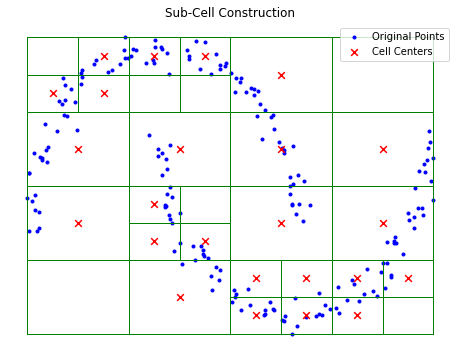

In [27]:
# With different k value
coreset_construction(moons, 3, D, eps, len(moons));

# Circles

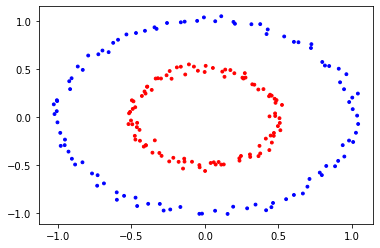

In [13]:
circles, circles_labels = sk.datasets.make_circles(n_samples=200, random_state=1, noise = 0.03, factor=0.5)
circles = circles.round(3)
plt.scatter(circles[:, 0], circles[:, 1], c=circles_labels, cmap="bwr", s=8);

The array is non-empty, proceeding with coreset construction algorithm
delta = 8.87571
cs = 14.82202
Number of guesses for opt approximation = 118

Iteration j = 0, with approximation Opt = (1+eps)^j = 1.0

Threshold value: 0.27737 Points in cell: 198
Current number of cells: 1
Threshold value: 0.55473 Points in cell: 51
Current number of cells: 4
Threshold value: 1.10946 Points in cell: 8
Current number of cells: 7
Threshold value: 2.21893 Points in cell: 0
Threshold value: 2.21893 Points in cell: 3
Current number of cells: 10
Threshold value: 4.43785 Points in cell: 0
Threshold value: 4.43785 Points in cell: 0
Threshold value: 4.43785 Points in cell: 0
Threshold value: 4.43785 Points in cell: 3
 Points in light cell:
 [[-0.599 -0.858]
 [-0.55  -0.817]
 [-0.6   -0.781]] 
Threshold value: 2.21893 Points in cell: 1
 Points in light cell:
 [[-0.883 -0.492]] 
Threshold value: 2.21893 Points in cell: 4
Current number of cells: 10
Threshold value: 4.43785 Points in cell: 2
 Points in light 

Threshold value: 5.3698 Points in cell: 0
Threshold value: 5.3698 Points in cell: 4
 Points in light cell:
 [[-0.24   0.479]
 [-0.164  0.524]
 [-0.191  0.517]
 [-0.134  0.443]] 
Threshold value: 5.3698 Points in cell: 4
 Points in light cell:
 [[-0.002  0.469]
 [-0.048  0.482]
 [ 0.005  0.533]
 [-0.075  0.525]] 
Threshold value: 1.34245 Points in cell: 7
Current number of cells: 7
Threshold value: 2.6849 Points in cell: 1
 Points in light cell:
 [[-0.794  0.64 ]] 
Threshold value: 2.6849 Points in cell: 4
Current number of cells: 10
Threshold value: 5.3698 Points in cell: 1
 Points in light cell:
 [[-0.725  0.653]] 
Threshold value: 5.3698 Points in cell: 0
Threshold value: 5.3698 Points in cell: 2
 Points in light cell:
 [[-0.655  0.675]
 [-0.697  0.692]] 
Threshold value: 5.3698 Points in cell: 1
 Points in light cell:
 [[-0.624  0.772]] 
Threshold value: 2.6849 Points in cell: 0
Threshold value: 2.6849 Points in cell: 2
 Points in light cell:
 [[-0.534  0.859]
 [-0.591  0.804]] 
Thr

 [[0.962 0.446]] 
Threshold value: 1.7868 Points in cell: 7
Current number of cells: 7
Threshold value: 3.5736 Points in cell: 0
Threshold value: 3.5736 Points in cell: 0
Threshold value: 3.5736 Points in cell: 3
 Points in light cell:
 [[0.204 0.97 ]
 [0.07  0.996]
 [0.194 0.989]] 
Threshold value: 3.5736 Points in cell: 4
Current number of cells: 10
Threshold value: 7.14721 Points in cell: 0
Threshold value: 7.14721 Points in cell: 2
 Points in light cell:
 [[0.427 0.911]
 [0.419 0.863]] 
Threshold value: 7.14721 Points in cell: 2
 Points in light cell:
 [[0.376 0.966]
 [0.316 0.965]] 
Threshold value: 7.14721 Points in cell: 0
Threshold value: 1.7868 Points in cell: 7
Current number of cells: 7
Threshold value: 3.5736 Points in cell: 4
Current number of cells: 10
Threshold value: 7.14721 Points in cell: 0
Threshold value: 7.14721 Points in cell: 0
Threshold value: 7.14721 Points in cell: 2
 Points in light cell:
 [[0.636 0.778]
 [0.605 0.782]] 
Threshold value: 7.14721 Points in cel

Threshold value: 10.46423 Points in cell: 2
 Points in light cell:
 [[0.276 0.411]
 [0.271 0.457]] 
Threshold value: 10.46423 Points in cell: 0
Threshold value: 2.61606 Points in cell: 9
Current number of cells: 7
Threshold value: 5.23211 Points in cell: 0
Threshold value: 5.23211 Points in cell: 4
 Points in light cell:
 [[1.04  0.245]
 [0.981 0.157]
 [1.002 0.203]
 [1.005 0.083]] 
Threshold value: 5.23211 Points in cell: 0
Threshold value: 5.23211 Points in cell: 5
 Points in light cell:
 [[0.946 0.29 ]
 [0.919 0.362]
 [0.845 0.531]
 [0.91  0.503]
 [0.962 0.446]] 
Threshold value: 2.61606 Points in cell: 7
Current number of cells: 7
Threshold value: 5.23211 Points in cell: 0
Threshold value: 5.23211 Points in cell: 0
Threshold value: 5.23211 Points in cell: 3
 Points in light cell:
 [[0.204 0.97 ]
 [0.07  0.996]
 [0.194 0.989]] 
Threshold value: 5.23211 Points in cell: 4
 Points in light cell:
 [[0.427 0.911]
 [0.376 0.966]
 [0.419 0.863]
 [0.316 0.965]] 
Threshold value: 2.61606 Poi

Threshold value: 9.26901 Points in cell: 0
Threshold value: 9.26901 Points in cell: 4
 Points in light cell:
 [[-0.038 -0.498]
 [-0.036 -0.521]
 [-0.149 -0.534]
 [ 0.001 -0.559]] 
Threshold value: 4.6345 Points in cell: 9
Current number of cells: 7
Threshold value: 9.26901 Points in cell: 5
 Points in light cell:
 [[-0.833 -0.469]
 [-0.928 -0.358]
 [-0.954 -0.291]
 [-0.981 -0.298]
 [-0.905 -0.432]] 
Threshold value: 9.26901 Points in cell: 0
Threshold value: 9.26901 Points in cell: 3
 Points in light cell:
 [[-1.003 -0.054]
 [-0.952 -0.233]
 [-0.984 -0.163]] 
Threshold value: 9.26901 Points in cell: 1
 Points in light cell:
 [[-0.52  -0.072]] 
Threshold value: 4.6345 Points in cell: 21
Current number of cells: 7
Threshold value: 9.26901 Points in cell: 8
 Points in light cell:
 [[-0.402 -0.291]
 [-0.402 -0.294]
 [-0.31  -0.372]
 [-0.442 -0.245]
 [-0.341 -0.241]
 [-0.416 -0.306]
 [-0.295 -0.402]
 [-0.357 -0.369]] 
Threshold value: 9.26901 Points in cell: 6
 Points in light cell:
 [[-0.1

 [[-0.258  0.978]
 [-0.343  0.933]
 [-0.469  0.874]
 [-0.408  0.897]
 [-0.329  0.917]] 
Threshold value: 18.06268 Points in cell: 4
 Points in light cell:
 [[-0.164  0.985]
 [-0.138  0.992]
 [-0.053  1.   ]
 [-0.007  1.036]] 
Threshold value: 4.51567 Points in cell: 45
Current number of cells: 4
Threshold value: 9.03134 Points in cell: 22
Current number of cells: 7
Threshold value: 18.06268 Points in cell: 0
Threshold value: 18.06268 Points in cell: 8
 Points in light cell:
 [[0.477 0.039]
 [0.454 0.223]
 [0.436 0.217]
 [0.474 0.191]
 [0.487 0.177]
 [0.524 0.127]
 [0.48  0.149]
 [0.443 0.233]] 
Threshold value: 18.06268 Points in cell: 8
 Points in light cell:
 [[0.255 0.41 ]
 [0.054 0.511]
 [0.133 0.419]
 [0.2   0.456]
 [0.118 0.473]
 [0.138 0.494]
 [0.173 0.489]
 [0.262 0.401]] 
Threshold value: 18.06268 Points in cell: 6
 Points in light cell:
 [[0.398 0.291]
 [0.276 0.411]
 [0.271 0.457]
 [0.322 0.341]
 [0.336 0.337]
 [0.363 0.287]] 
Threshold value: 9.03134 Points in cell: 9
 Poin

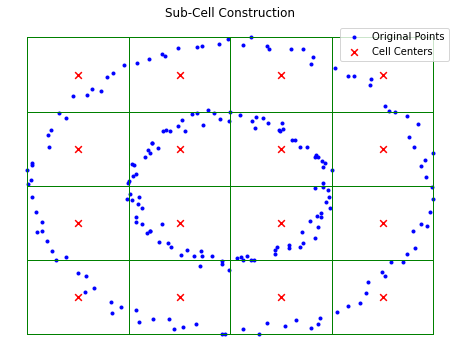

In [28]:
coreset_construction(circles, k, D, eps, len(circles));